라이브러리 버전 확인

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

### 1) 데이터 준비와 확인

In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

### 2) 데이터로더 구성

In [4]:
len(train_data)

150000

In [5]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [6]:
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [7]:
train_data[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [8]:
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any') 

In [9]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-3)
    vocab = ['<PAD>', '<BOS>', '<UNK>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [10]:
X_train.__len__(), y_train.shape

(146182, (146182,))

In [11]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [12]:
word_to_index={word:index for index, word in index_to_word.items()}

In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [14]:
X_train[0]

[31, 73, 918, 3, 3, 38, 227, 19, 32, 747]

In [15]:
sentences = []
for sentence in train_data['document']:
    sentences.append(tokenizer.morphs(str(sentence)))
X_train = get_encoded_sentences(sentences, word_to_index)
X_train[:10]

[[1, 31, 73, 918, 3, 3, 38, 227, 19, 32, 747],
 [1,
  1027,
  3,
  10,
  518,
  548,
  686,
  4,
  119,
  3,
  69,
  1638,
  51,
  924,
  1005,
  14,
  43,
  390],
 [1, 23, 204, 2],
 [1, 8408, 157, 3924, 3, 3, 297, 93, 2, 16, 5, 3, 3, 57, 3478],
 [1,
  2,
  2,
  8893,
  1107,
  51,
  2,
  2831,
  59,
  4,
  13,
  2757,
  40,
  1187,
  34,
  350,
  41,
  21,
  39,
  59,
  2,
  2,
  2,
  426,
  2,
  3101,
  1765,
  5],
 [1,
  674,
  2,
  2,
  130,
  419,
  184,
  1546,
  711,
  64,
  1693,
  714,
  52,
  374,
  191,
  270,
  4,
  3,
  68,
  3,
  10,
  2178,
  121,
  2,
  749,
  3],
 [1, 252, 2, 380, 8, 383, 2011, 54, 14, 816, 5, 3],
 [1,
  231,
  1449,
  2,
  143,
  5,
  424,
  755,
  2,
  2,
  51,
  1531,
  2,
  289,
  98,
  249,
  3,
  3,
  27,
  854,
  28,
  352,
  651,
  539,
  508,
  582,
  5,
  3317,
  3,
  8894,
  21,
  1459,
  1459,
  3,
  3,
  2,
  70,
  2,
  303,
  2,
  16,
  5,
  51,
  103,
  7,
  2,
  76,
  21,
  2,
  42],
 [1, 127, 2, 16, 22, 2, 93, 15, 2, 289, 26, 47, 2, 4]

In [16]:
X_train.__len__()

146182

In [17]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


#### - index_to_word를 이용하여 X_train 인코딩

In [18]:
sentences = []
for sentence in test_data['document']:
    sentences.append(tokenizer.morphs(str(sentence)))
X_test = get_encoded_sentences(sentences, word_to_index)
X_test[:10]

[[1, 831, 129],
 [1, 2],
 [1,
  84,
  110,
  2,
  57,
  2,
  2,
  3,
  69,
  949,
  331,
  43,
  37,
  99,
  36,
  640,
  2,
  3556,
  72,
  916],
 [1,
  95,
  7,
  14,
  2,
  43,
  230,
  136,
  356,
  128,
  3,
  10,
  152,
  53,
  6,
  9,
  41,
  2,
  2,
  3,
  69],
 [1,
  130,
  1113,
  21,
  72,
  20,
  458,
  231,
  2141,
  121,
  558,
  8,
  595,
  3,
  3,
  62,
  130,
  1113,
  28,
  634,
  345,
  2,
  2,
  843,
  7,
  11,
  7,
  294,
  17,
  17],
 [1, 236, 2, 53, 2, 159, 12, 55, 2, 236, 4],
 [1, 635, 2, 106],
 [1,
  1096,
  451,
  591,
  40,
  2,
  77,
  2,
  4916,
  1776,
  16,
  2,
  1544,
  4300,
  184,
  2,
  12,
  5721,
  2,
  2940,
  11,
  198],
 [1,
  562,
  1274,
  47,
  2,
  2,
  684,
  4,
  233,
  7,
  6,
  87,
  16,
  29,
  2993,
  492,
  5,
  125,
  122,
  50,
  2,
  26,
  47,
  2,
  2960,
  2,
  233,
  2,
  1208,
  2,
  31,
  1408,
  5,
  2,
  35,
  2,
  4,
  2,
  126,
  130,
  477,
  1576,
  317,
  2,
  5],
 [1,
  2973,
  2,
  1451,
  613,
  2,
  2,
  2,
  825,
 

#### - index_to_word를 이용하여 X_test 인코딩

In [19]:
X_test[0]

[1, 831, 129]

In [20]:
print(get_decoded_sentence(X_test[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

굳 ㅋ
라벨:  0


In [21]:
print(len(X_train))
print(len(X_test))

146182
49157


In [22]:
X_train.__len__(), y_train.shape

(146182, (146182,))

### 3) 모델 구성을 위한 데이터 분석 및 가공

In [23]:
total_data_text = X_train + X_test
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  19.72297390690031
문장길이 최대 :  117
문장길이 표준편차 :  15.329503337998032
pad_sequences maxlen :  50
전체 문장의 0.9346725436292804%가 maxlen 설정값 이내에 포함됩니다. 


### 4) 모델 구성 및 validation set 구성

In [24]:
import tensorflow as tf
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)
print(x_test.shape)

(146182, 50)
(49157, 50)


In [25]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 50)
(136182,)


#### 1-D Convolution Neural Network(1-D CNN)

In [26]:
vocab_size = 10000
word_vector_dim = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

### 5) 모델 훈련 개시

In [27]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 4s 6ms/step - loss: 0.5509 - accuracy: 0.7007 - val_loss: 0.4497 - val_accuracy: 0.7765
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.4244 - accuracy: 0.7943 - val_loss: 0.4375 - val_accuracy: 0.7824
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3950 - accuracy: 0.8105 - val_loss: 0.4397 - val_accuracy: 0.7791
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3687 - accuracy: 0.8243 - val_loss: 0.4465 - val_accuracy: 0.7793
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3391 - accuracy: 0.8407 - val_loss: 0.4582 - val_accuracy: 0.7804
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3070 - accuracy: 0.8581 - val_loss: 0.4838 - val_accuracy: 0.7762
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2749 - accuracy: 0.8744 - val_loss: 0.5151 - val_accuracy: 0.7716
Epoch 

In [28]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6636 - accuracy: 0.7553
[0.6635825037956238, 0.7552739381790161]


### 6) Loss, Accuracy 그래프 시각화

In [29]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


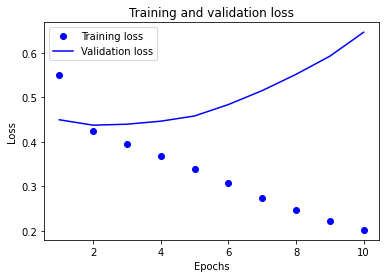

In [30]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # bo는 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

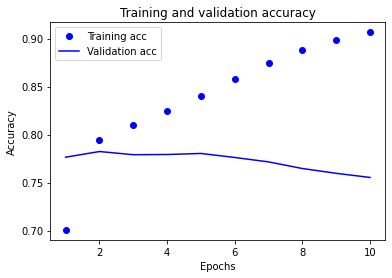

In [31]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### -2) GlobalMaxPooling1D()

In [32]:
vocab_size = 100000   # 어휘 사전의 크기
word_vector_dim = 32   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          3200000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 3,200,273
Trainable params: 3,200,273
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 2s 5ms/step - loss: 0.5290 - accuracy: 0.7832 - val_loss: 0.3740 - val_accuracy: 0.8370
Epoch 2/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3434 - accuracy: 0.8529 - val_loss: 0.3407 - val_accuracy: 0.8502
Epoch 3/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3016 - accuracy: 0.8740 - val_loss: 0.3363 - val_accuracy: 0.8537
Epoch 4/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2741 - accuracy: 0.8876 - val_loss: 0.3401 - val_accuracy: 0.8551
Epoch 5/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2518 - accuracy: 0.8989 - val_loss: 0.3502 - val_accuracy: 0.8530
Epoch 6/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2320 - accuracy: 0.9089 - val_loss: 0.3603 - val_accuracy: 0.8528
Epoch 7/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2142 - accuracy: 0.9166 - val_loss: 0.3714 - val_accuracy: 0.8539
Epoch 

In [34]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4408 - accuracy: 0.8386
[0.44077736139297485, 0.8385987877845764]


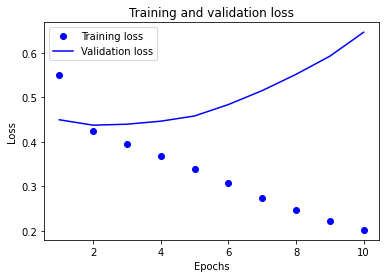

In [35]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

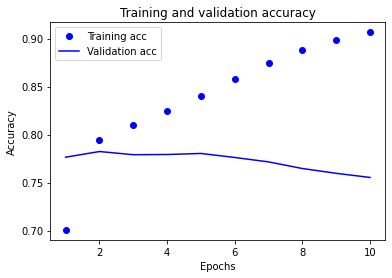

In [36]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### -3) RNN

In [37]:
vocab_size = 10000
word_vector_dim = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 4s 8ms/step - loss: 0.4622 - accuracy: 0.7853 - val_loss: 0.3501 - val_accuracy: 0.8509
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3363 - accuracy: 0.8578 - val_loss: 0.3410 - val_accuracy: 0.8517
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3188 - accuracy: 0.8657 - val_loss: 0.3401 - val_accuracy: 0.8512
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3084 - accuracy: 0.8709 - val_loss: 0.3382 - val_accuracy: 0.8521
Epoch 5/10
266/266 [==============================] - 1s 6ms/step - loss: 0.2994 - accuracy: 0.8748 - val_loss: 0.3378 - val_accuracy: 0.8507
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2915 - accuracy: 0.8785 - val_loss: 0.3344 - val_accuracy: 0.8549
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2786 - accuracy: 0.8844 - val_loss: 0.3373 - val_accuracy: 0.8563
Epoch 

In [39]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3824 - accuracy: 0.8497
[0.38239550590515137, 0.8497467041015625]


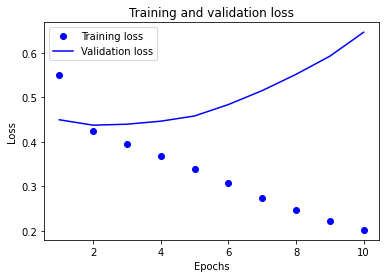

In [40]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

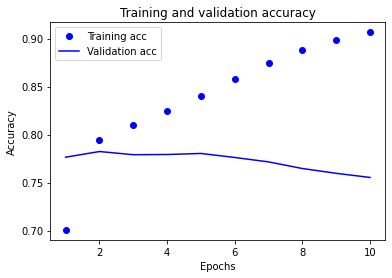

In [41]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [42]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)   # shape: (vocab_size, embedding_dim)

(10000, 16)


In [43]:
# 학습한 Embedding 파라미터를 파일에 저장
import os

vocab_size = 9999
word_vector_dim = 16
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/1D_CNN_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-3, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(3, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, ])))))
f.close()

In [44]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("영화")

[('그분', 0.7934764623641968),
 ('다', 0.7769489288330078),
 ('음', 0.769051194190979),
 ('코난', 0.7033528089523315),
 ('장수', 0.6990383863449097),
 ('드라마', 0.6824782490730286),
 ('믄', 0.6791669726371765),
 ('샤론스톤', 0.6673958897590637),
 ('빛', 0.6656601428985596),
 ('중계', 0.6586123108863831)]

In [45]:
word_vectors.similar_by_word("사랑")

[('돌파', 0.9773086309432983),
 ('백배', 0.9764727354049683),
 ('독도', 0.976152241230011),
 ('조아', 0.9732014536857605),
 ('씁시다', 0.9710327982902527),
 ('사전', 0.9700942039489746),
 ('한석규', 0.9697375893592834),
 ('섬세', 0.9696300625801086),
 ('데요', 0.9692950248718262),
 ('여태껏', 0.9683948159217834)]

- 학습된 임베딩 레이어로 유사한 단어를 확인하였을 때 관련도가 낮은 단어들이 결과값으로 나왔다.

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [46]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/aiffel/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [47]:
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [48]:
vocab_size = 9999   # 100000으로 설정했을 때 오류가 나서 9999로 설정함
word_vectors_dim = 100   # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vectors_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(3, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [49]:
from tensorflow.keras.initializers import Constant

vocab_size = 9999
word_vector_dim = 100

tf.random.set_seed(2022)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning)
model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           999900    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,125,469
Trainable params: 1,125,469
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습의 진행
opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=216,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
631/631 [==============================] - 7s 8ms/step - loss: 0.5746 - accuracy: 0.6922 - val_loss: 0.4975 - val_accuracy: 0.7581
Epoch 2/20
631/631 [==============================] - 5s 7ms/step - loss: 0.4665 - accuracy: 0.7818 - val_loss: 0.4371 - val_accuracy: 0.8003
Epoch 3/20
614/631 [============================>.] - ETA: 0s - loss: 0.4234 - accuracy: 0.8075

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

In [ ]:
# word2vec으로 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 

vocab_size = 9999
word_vector_dim = 100
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-3, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(3, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, ])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors.wv = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.wv.similar_by_word("영화")

In [ ]:
word_vectors.wv.similar_by_word("사랑")

- 한국어 word2vec을 사용하여 분석했을 때 단어와 의미상 더 적절한 단어가 결과값으로 나왔다.

### 회고

<ol>
<ul> 1. <strong>프로젝트 설명</strong>
    <p> 영화 리뷰 감성 분석을 진행하여 긍정/부정을 분류하는 딥러닝 모델을 구축하였다. 긍정, 부정이 구분되어 있는 데이터이기 때문에 라벨을 더 정확하게 구분하는 모델을 만드는 것이 목표이다.</p>
</ul>
<ul> 2. <strong>시도한 것들</strong>
    <li> 1D CNN, LSTM, Maxpooling CNN 등 다양한 모델을 사용하여 학습을 시도해보았다.</li>
    <li> 정확도를 높이기 위해서 모델에서 파라미터를 조절하고 dropout을 진행하였다. optimizer에서는 learning_rate를 설정하고, epoch 등을 바꾸어가며 정확도를 높였다.</li>
</ul>
<ul> 3. <strong>어려웠던 점</strong>
    <li> index_to_word와 word_to_index라는 단어장을 만드는 과정이 어려웠다. 딕셔너리에 BOSE, PAD, UNK 같은 특수문자를 지정해주고 토큰화한 단어들을 모두 인덱스로 바꿔야했다. dataframe 안의 문장들을 토큰화하는 과정이 어려웠가.
    <li> 학습을 위해 train, test 데이터를 만드는 과정에서 인코딩 전, 후로 X_train의 길이가 달랐는데 그 문제의 원인을 찾지 못해 애를 먹었다. 데이터로더 구성 단계에서 dropna를 적용했는데도 결측치가 제대로 제거되지 않고 남아있었기 때문이었다. 함수 안에서 dropna를 진행했기 때문에 전체적으로는 결측치 제거가 제대로 되지 않은 상황이었다.</li>
</ul>
<ul> 4. <strong>알게된 점</strong>
    <li> 함수 안에서 사용하는 변수는 지역변수가 되어서, 출력하지 않으면 함수 밖에서 사용할 수 없다.</li>
</ul>
<ul> 5. <strong>아쉬운 점</strong>
    <li> regex를 이용하여 한국어 전처리를 하면 실행시간이 너무 오래 걸려 다운이 되는 바람에 따로 정규표현식을 이용한 전처리를 사용하지 못했다.</li>
    <li> 정규표현식을 이용한 한국어 문자열 정제하는 방법을 좀 더 공부하여 이번 프로젝트에 적용해보고 싶다.</li>
</ul>
</ol>